# 1D Metropolis–Hastings with theano and tensorflow
A small benchmark on speed etc, also an idea to use control flow to get full MH trace.

In [2]:
%pylab inline
import numpy as np
import pymc3 as pm

import theano.tensor as tt
import theano

pm.__version__

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'3.3'

Record in the PyMC3 doc: [How PyMC3 uses Theano](http://docs.pymc.io/theano.html#how-pymc3-uses-theano), the most important side effect of a model construction is the model log-likelihood function and its gradient: it is the non-normalized posterior distribution, proportional to likelihood times prior.

In [3]:
data = 10.
# prior for mu and sd
prior = [0., 100.]

In [4]:
theano.config.compute_test_value='off'
mu_th = tt.scalar('mu')
logp_th = pm.Normal.dist(mu=prior[0], sd=prior[1]).logp(mu_th)
logp_th += pm.Normal.dist(mu_th, 1.).logp(data)

In [5]:
logp_th.eval({mu_th: 0.})

array(-56.44304725)

Similarly, we can set up the logp in tensorflow as below:

In [6]:
import tensorflow as tf
from tensorflow.contrib import distributions as tfd
from tensorflow.contrib import bayesflow as bf
from tensorflow.contrib.bayesflow.python.ops import \
    metropolis_hastings_impl as mh

tf.__version__

Instructions for updating:
Use the retry module or similar alternatives.


'1.6.0-rc1'

In [7]:
mu0 = tf.Variable(0., tf.float64)

In [8]:
mu_tf = tfd.Normal(loc=prior[0], scale=prior[1])

In [9]:
mu_tf.log_prob(mu0)

<tf.Tensor 'Normal_1/log_prob/sub:0' shape=() dtype=float32>

In [10]:
y_tf = tfd.Normal(loc=mu0, scale=1.)
logp_tf = y_tf.log_prob(data) + mu_tf.log_prob(mu0)

In [11]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(logp_tf))

-56.443047


Metropolis–Hastings algorithm, with kernel and control flow in numpy:

In [12]:
scale = 1.
nsample = 10000

Tensorflow version:

In [13]:
%%time

trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

with sess.as_default():
    logp0 = logp_tf.eval({mu0: 0.})

trace['mu'][0] = 0.
trace['logp'][0] = logp0
trace['accept'][0] = 1

for s in range(1, nsample):
    mu_ = trace['mu'][s-1]
    logp_ = trace['logp'][s-1]
    mu_p = mu_ + np.random.randn()*scale

    # evaluation of logp
    with sess.as_default():
        logp_p = logp_tf.eval({mu0: mu_p})

    if np.log(np.random.rand()) < logp_p-logp_:
        trace['mu'][s] = mu_p
        trace['logp'][s] = logp_p
        trace['accept'][s] = 1
    else:
        trace['mu'][s] = mu_
        trace['logp'][s] = logp_
        trace['accept'][s] = 0

CPU times: user 1.7 s, sys: 76 ms, total: 1.77 s
Wall time: 1.37 s


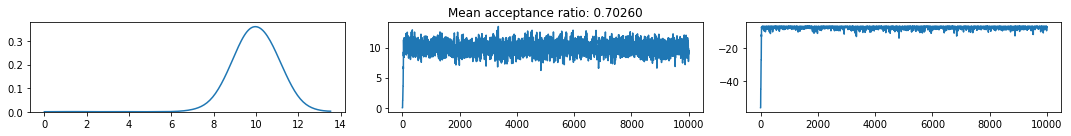

In [14]:
trace_tf = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();

Theano version:

In [15]:
%%time
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

logp0 = logp_th.eval({mu_th: 0.})
  
trace['mu'][0] = 0.
trace['logp'][0] = logp0
trace['accept'][0] = 1

for s in range(1, nsample):
    mu_ = trace['mu'][s-1]
    logp_ = trace['logp'][s-1]
    mu_p = mu_ + np.random.randn()*scale

    # evaluation of logp
    logp_p = logp_th.eval({mu_th: mu_p})

    if np.log(np.random.rand()) < logp_p-logp_:
        trace['mu'][s] = mu_p
        trace['logp'][s] = logp_p
        trace['accept'][s] = 1
    else:
        trace['mu'][s] = mu_
        trace['logp'][s] = logp_
        trace['accept'][s] = 0

CPU times: user 396 ms, sys: 96 ms, total: 492 ms
Wall time: 377 ms


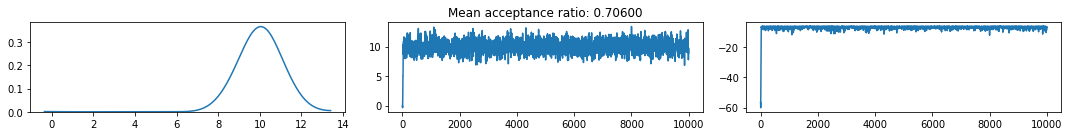

In [16]:
trace_th = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();

As you can see from the timing above, the sampling is way faster in theano. Basically, if we are going to do everything in an imperative programming style, the speed comes down to how fast you can evaluate logp (and dlogp in gradient based method).

Using the MH from tensorflow is pretty fast, however, it is not quite what we used to as it does not output the whole chain, instead it ouputs the final state. In a way you can use it as if it output a chain (or a particle filter / SMC). For example, specifying the number of chain = nsample we can treat the final output as samples from the posterior.

In [17]:
tf.reset_default_graph()
# Generate nsample initial values randomly. Each of these would be an
# independent starting point for a Markov chain.
state = tf.get_variable(
    "state",
    initializer=tf.random_normal([nsample],
                                 mean=0.,
                                 dtype=tf.float32,
                                 seed=42)*100.)

# Computes the log(p(x))
def log_density(x):
    mu = tfd.Normal(loc=0., scale=100.)
    y = tfd.Normal(loc=x, scale=1.)
    logp2 = y.log_prob(data)+mu.log_prob(x)
    return logp2

# Initial log-density value
state_log_density = tf.get_variable(
    "state_log_density",
    initializer=log_density(state.initialized_value()))

# A variable to store the log_acceptance_ratio:
log_acceptance_ratio = tf.get_variable(
    "log_acceptance_ratio",
    initializer=tf.zeros([nsample], dtype=tf.float32))

# Generates random proposals
def random_proposal(x):
      return (x + tf.random_normal(tf.shape(x), mean=0., stddev=scale,
                                dtype=x.dtype, seed=12)), None

In [18]:
%%time
#  Create the op to propagate the chain for 100 steps.
stepper = mh.evolve(
    state, state_log_density, log_acceptance_ratio,
    log_density, random_proposal, n_steps=1000, seed=123)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Run the chains for a total of 1000 steps
    # Executing the stepper advances the chain to the next state.
    sess.run(stepper)
    samples, sample_log_density = sess.run(
        [state, state_log_density])

trace['mu'] = samples
trace['logp'] = sample_log_density
trace['accept'] = 0

CPU times: user 668 ms, sys: 60 ms, total: 728 ms
Wall time: 237 ms


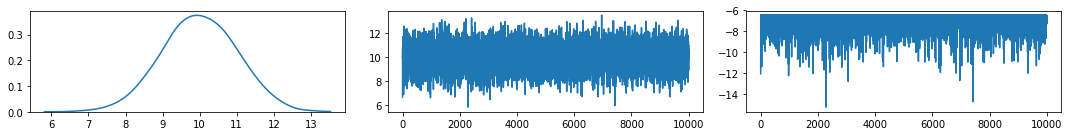

In [19]:
trace_tf1 = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[2].plot(trace['logp'])
plt.tight_layout();

It is fast.

Below, we try to use multiple way to see if we can get a speed up from tensorflow, but getting the full chain:
- Eager (In a separate notebook as Eager mode has to be turn on in the very beginning. Spoiler: it is very slow)
- MH kernel from bayesflow
- Modify the MH sampler from bayesflow to get the full chain

In [20]:
from tensorflow.python.ops import variable_scope
from tensorflow.python.ops import array_ops

tf.reset_default_graph()

# Computes the log(p(x))
def log_density(x):
    mu = tfd.Normal(loc=0., scale=100.)
    y = tfd.Normal(loc=x, scale=1.)
    logp2 = y.log_prob(data)+mu.log_prob(x)
    return logp2

state = variable_scope.get_variable('state', initializer=0.0)

# Initial log-density value
state_log_density = variable_scope.get_variable(
    'state_log_density',
    initializer=log_density(state.initialized_value()))

# A variable to store the log_acceptance_ratio:
log_accept_ratio = variable_scope.get_variable(
    'log_accept_ratio', initializer=0.)

# Generates random proposals
def random_proposal(x):
      return (x + tf.random_normal(tf.shape(x), mean=0., stddev=scale,
                                dtype=x.dtype, seed=12)), None

In [21]:
%%time
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

#  Create the op to propagate the chain for 100 steps.
stepper = mh.evolve(
    state, state_log_density, log_accept_ratio,
    log_density, random_proposal)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for s in np.arange(nsample):
        sess.run(stepper)
        trace['mu'][s] = sess.run(state)
        trace['logp'][s] = sess.run(state_log_density)
    
trace['accept'][1:] = trace['mu'][1:] != trace['mu'][:-1]

CPU times: user 4.76 s, sys: 580 ms, total: 5.34 s
Wall time: 2.97 s


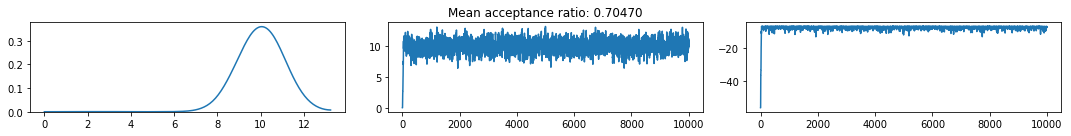

In [22]:
trace_tf2 = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();

Still pretty slow, we can get the kernel and just update the state instead:

In [23]:
tf.reset_default_graph()

from tensorflow.python.ops import init_ops
from tensorflow.python.ops import variable_scope
from tensorflow.python.ops import variables

# Computes the log(p(x))
def log_density(x):
    mu = tfd.Normal(loc=0., scale=100.)
    y = tfd.Normal(loc=x, scale=1.)
    logp2 = y.log_prob(data)+mu.log_prob(x)
    return logp2

state = variable_scope.get_variable("state", initializer=0.)

# Initial log-density value
state_log_density = tf.get_variable(
    "state_log_density",
    initializer=log_density(state.initialized_value()))

# A variable to store the accept:
accept = tf.get_variable(
    "accept",
    initializer=tf.zeros([], dtype=tf.bool))


new_state, kernel_results = mh.kernel(
        target_log_prob_fn=log_density,
        proposal_fn=mh.proposal_normal(scale=1.),
        current_state=state, 
        current_target_log_prob=state_log_density)

mu_update = state.assign(new_state)
logp_update = state_log_density.assign(kernel_results.current_target_log_prob)
accpet_update = accept.assign(kernel_results.is_accepted)

In [24]:
%%time
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    mu_samples = []
    logp_samples = []
    accept_samples = []
    for s in range(nsample):
        mu_sample, logp_sample, accept_sample = sess.run(
            [mu_update, logp_update, accpet_update])
        trace['mu'][s] = mu_sample
        trace['logp'][s] = logp_sample
        trace['accept'][s] = accept_sample

CPU times: user 2.3 s, sys: 272 ms, total: 2.57 s
Wall time: 1.5 s


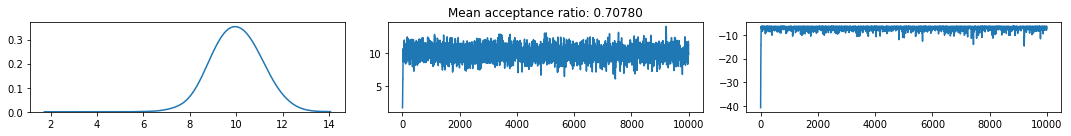

In [25]:
trace_tf3 = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();

Modify the while loop via tensorflow control flow to get the full chain: It is possible to go stateful

In [26]:
%%time
ndim = 100
nstep = 10000

tf.reset_default_graph()
i0 = tf.constant(0)
m0 = tf.ones([1, ndim])
walk = tf.random_normal([1, ndim], mean=0., stddev=1.)
c = lambda i, m: i < nstep
b = lambda i, m: [i+1, 
                  tf.concat([m, m[-1]+tf.random_normal([1, ndim], mean=0., stddev=1.)], 
                            axis=0)]
r = tf.while_loop(
    c, b, loop_vars=[i0, m0],
    shape_invariants=[i0.get_shape(), tf.TensorShape([None, ndim])])

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    r_ = sess.run(r)

CPU times: user 3.4 s, sys: 448 ms, total: 3.85 s
Wall time: 788 ms


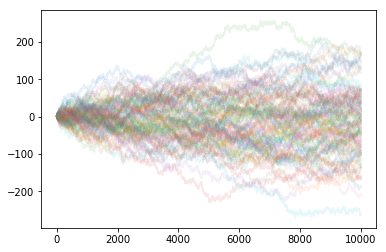

In [27]:
plt.plot(r_[1], alpha=.1);

In [28]:
tf.reset_default_graph()
# Generate nsample initial values randomly. Each of these would be an
# independent starting point for a Markov chain.
state = variable_scope.get_variable('state', initializer=[0.0])

# Computes the log(p(x))
def log_density(x):
    mu = tfd.Normal(loc=0., scale=100.)
    y = tfd.Normal(loc=x, scale=1.)
    logp2 = y.log_prob(data)+mu.log_prob(x)
    return logp2

# Initial log-density value
state_log_density = tf.get_variable(
    "state_log_density",
    initializer=log_density(state.initialized_value()))

# A variable to store the log_acceptance_ratio:
log_acceptance_ratio = tf.get_variable(
    "log_acceptance_ratio",
    initializer=tf.zeros([1], dtype=tf.float32))

# Generates random proposals
def random_proposal(x):
      return (x + tf.random_normal(tf.shape(x), mean=0., stddev=scale,
                                dtype=x.dtype, seed=12)), None

In [29]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops

def mhevolve(initial_sample,
           initial_log_density,
           initial_log_accept_ratio,
           target_log_prob_fn,
           proposal_fn,
           n_steps=1,
           seed=None,
           name=None):
    with ops.name_scope(name, "metropolis_hastings", [initial_sample]):
        current_state = tf.expand_dims(initial_sample, 0)
        current_target_log_prob = tf.expand_dims(initial_log_density, 0)
        log_accept_ratio = initial_log_accept_ratio

        def step(i, current_state, current_target_log_prob, log_accept_ratio):
            """Wrap single Markov chain iteration in `while_loop`."""
            next_state, kernel_results = mh.kernel(
                      target_log_prob_fn=target_log_prob_fn,
                      proposal_fn=proposal_fn,
                      current_state=current_state[-1, :],
                      current_target_log_prob=current_target_log_prob[-1, :],
                      seed=seed)
            accepted_log_prob = kernel_results.current_target_log_prob
            log_accept_ratio = kernel_results.log_accept_ratio
            current_state = tf.concat([current_state, tf.expand_dims(next_state, 0)], 
                            axis=0)
            current_target_log_prob = tf.concat([current_target_log_prob,
                                                 tf.expand_dims(accepted_log_prob, 0)], 
                            axis=0)
            return i + 1, current_state, current_target_log_prob, log_accept_ratio
        
        i0 = tf.constant(0)
        
        (_, accepted_state, accepted_target_log_prob, accepted_log_accept_ratio) = (
            control_flow_ops.while_loop(
                cond=lambda i, *ignored_args: i < n_steps,
                body=step,
                loop_vars=[
                    i0,  # i
                    current_state,
                    current_target_log_prob,
                    log_accept_ratio,
                ],
                # the magic here
                shape_invariants=[
                    i0.get_shape(),
                    tf.TensorShape([None, 1]),
                    tf.TensorShape([None, 1]),
                    log_accept_ratio.get_shape(),
                ],
                parallel_iterations=1 if seed is not None else 10,
                # TODO(b/73775595): Confirm optimal setting of swap_memory.
                swap_memory=1))

        forward_step = control_flow_ops.group(
            accepted_target_log_prob,
            accepted_state,
            accepted_log_accept_ratio
        )

    return accepted_state, accepted_target_log_prob, accepted_log_accept_ratio

In [30]:
%%time
#  Create the op to propagate the chain for 100 steps.
accepted_state, accepted_target_log_prob, accepted_log_accept_ratio = mhevolve(
    state, state_log_density, log_acceptance_ratio,
    log_density, random_proposal, n_steps=nsample, seed=123)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Run the chains for a total of 1000 steps
    # Executing the stepper advances the chain to the next state.
    samples, alog_prob, a_ratio = sess.run(
        [accepted_state, accepted_target_log_prob, accepted_log_accept_ratio])

CPU times: user 1.54 s, sys: 252 ms, total: 1.79 s
Wall time: 735 ms


In [31]:
trace = dict(mu=np.zeros(nsample),
             logp=np.zeros(nsample),
             accept=np.zeros(nsample))

trace['mu'] = samples[1:].squeeze()
trace['logp'] = alog_prob[1:].squeeze()
trace['accept'][1:] = trace['mu'][1:] != trace['mu'][:-1]

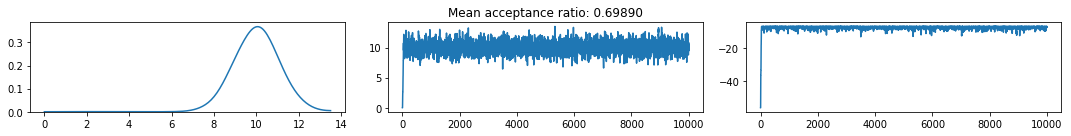

In [32]:
trace_tf3 = trace
_, ax = plt.subplots(1, 3, figsize=(15, 2))
pm.kdeplot(trace['mu'], ax=ax[0])
ax[1].plot(trace['mu'])
ax[1].set_title('Mean acceptance ratio: {:.5f}'
                .format(trace['accept'].mean()))
ax[2].plot(trace['logp'])
plt.tight_layout();

In [33]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0., sd=100.)
    y = pm.Normal('y', mu=mu, sd=1., observed=data)
    trace = pm.sample(10000, tune=0, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
100%|██████████| 10000/10000 [00:01<00:00, 9129.99it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '2130' (I am process '2131')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2130' (I am process '2132')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '2131' (I am process '2132')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
The number of effective samples is smaller than 25% for some parameters

In [34]:
model.logp({'mu': 1.})

array(-46.94309725)

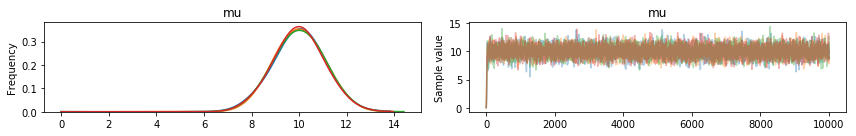

In [35]:
pm.traceplot(trace);